In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

**Data loading and preprocessing**

In [3]:
#load the dataset and print the first few rows
df = pd.read_csv('HR_data.csv')

print(df.head())
df.isna().sum()

   Unnamed: 0    HR_Mean  HR_Median    HR_std  HR_Min  HR_Max     HR_AUC  \
0           0  77.965186      78.00  3.345290   73.23   83.37  22924.945   
1           1  70.981097      70.57  2.517879   67.12   78.22  21930.400   
2           2  73.371959      73.36  3.259569   67.88   80.22  21647.085   
3           3  78.916822      77.88  4.054595   72.32   84.92  25258.905   
4           4  77.322226      74.55  6.047603   70.52   90.15  23890.565   

     Round   Phase  Individual  Puzzler  Frustrated Cohort  
0  round_3  phase3           1        1           1   D1_1  
1  round_3  phase2           1        1           5   D1_1  
2  round_3  phase1           1        1           0   D1_1  
3  round_2  phase3           1        1           1   D1_1  
4  round_2  phase2           1        1           5   D1_1  


Unnamed: 0    0
HR_Mean       0
HR_Median     0
HR_std        0
HR_Min        0
HR_Max        0
HR_AUC        0
Round         0
Phase         0
Individual    0
Puzzler       0
Frustrated    0
Cohort        0
dtype: int64

Frustrated
0    29
1    45
2    31
3    16
4    23
5    14
6     5
7     2
8     3
Name: count, dtype: int64


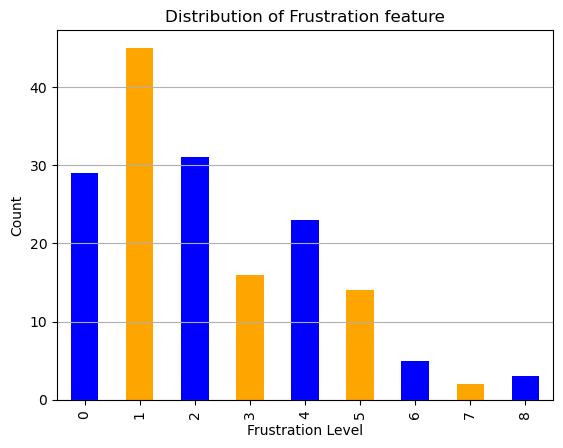

In [4]:
#print and plot the distribution of the 'Frustrated' column
print(df['Frustrated'].value_counts().sort_index())
# Plotting the distribution of 'Frustrated' column
df['Frustrated'].value_counts().sort_index().plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('Frustration Level')
plt.ylabel('Count')
plt.title('Distribution of Frustration feature')
plt.grid(axis='y')
plt.show()

In [5]:
#define the features and the target variable
numeric_features = ['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC']
categorical_features = ['Round', 'Phase', 'Cohort']
features = numeric_features + categorical_features

#define X and y
X = df[features]
y = df['Frustrated']

In [6]:
#preprocess the features by standardizing numeric features and one-hot encoding categorical features
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

**Random Forest Classifier**

In [7]:
#define the model pipeline with preprocessing and a Random Forest classifier
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
#use GroupKFold for cross-validation to keep the data from each individual in one fold
groups = df['Individual']
cv = GroupKFold(n_splits=5)

y_pred_rf = cross_val_predict(pipeline_rf, X, y, cv=cv, groups=groups)

Classification Report:

              precision    recall  f1-score   support

           0       0.13      0.14      0.14        29
           1       0.27      0.36      0.30        45
           2       0.23      0.26      0.24        31
           3       0.14      0.06      0.09        16
           4       0.24      0.17      0.20        23
           5       0.00      0.00      0.00        14
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         3

    accuracy                           0.20       168
   macro avg       0.11      0.11      0.11       168
weighted avg       0.18      0.20      0.19       168



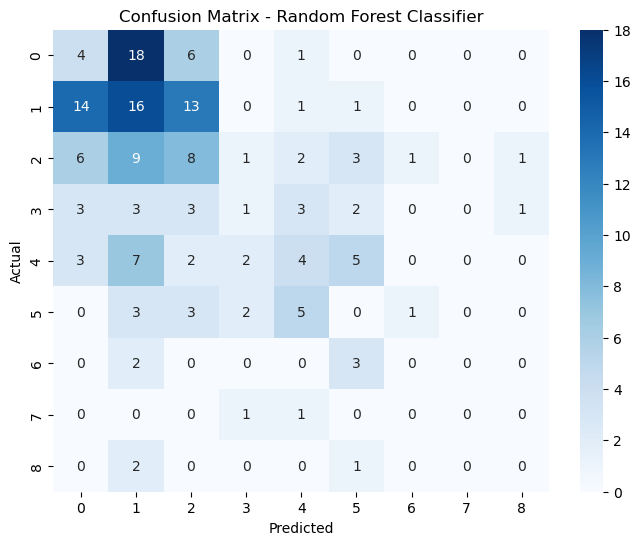

In [8]:
#printing the classification report and confusion matrix
print("Classification Report:\n")
print(classification_report(y, y_pred_rf, zero_division=0))

cm = confusion_matrix(y, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [9]:
#creating a new binned target variable due to class imbalance
def bin_frustration(val):
    if val <= 2:
        return 0 #low frustration
    elif val <= 5:
        return 1 #medium frustration
    else:
        return 2 #high frustration
    
#apply binning function
y_binned = df['Frustrated'].apply(bin_frustration)

print("Binned Frustration Levels given in %:\n")
print((y_binned.value_counts().sort_index()/168)*100)

Binned Frustration Levels given in %:

Frustrated
0    62.500000
1    31.547619
2     5.952381
Name: count, dtype: float64


Classification Report for Binned Target Variable:

              precision    recall  f1-score   support

           0       0.76      0.89      0.82       105
           1       0.59      0.49      0.54        53
           2       0.00      0.00      0.00        10

    accuracy                           0.71       168
   macro avg       0.45      0.46      0.45       168
weighted avg       0.66      0.71      0.68       168



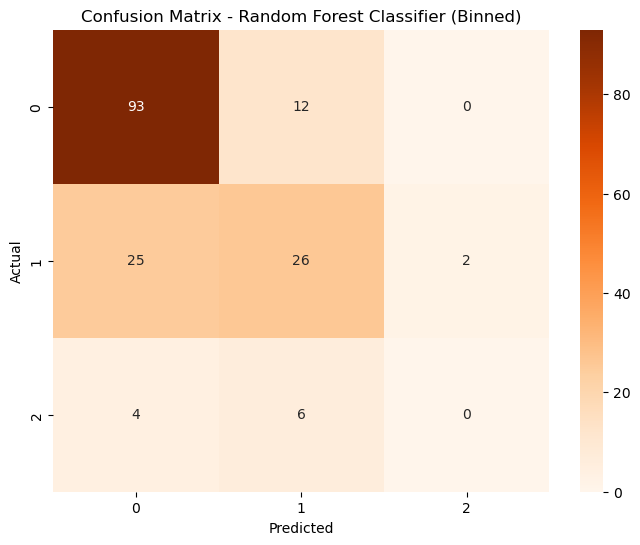

In [ ]:
#redefine the model pipeline with the binned target variable
y = y_binned

pipeline_rf_binned = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42)  )
])

#cross-validate the model with the binned target variable
y_pred_rf_binned = cross_val_predict(pipeline_rf_binned, X, y, cv=cv, groups=groups)
#printing the classification report and confusion matrix for binned target variable
print("Classification Report for Binned Target Variable:\n")
print(classification_report(y, y_pred_rf_binned, zero_division=0))


cm_binned = confusion_matrix(y, y_pred_rf_binned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_binned, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - Random Forest Classifier (Binned)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Logistic Regression Classifier**

Classification report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.73      0.87      0.79       105
           1       0.56      0.43      0.49        53
           2       0.00      0.00      0.00        10

    accuracy                           0.68       168
   macro avg       0.43      0.43      0.43       168
weighted avg       0.64      0.68      0.65       168



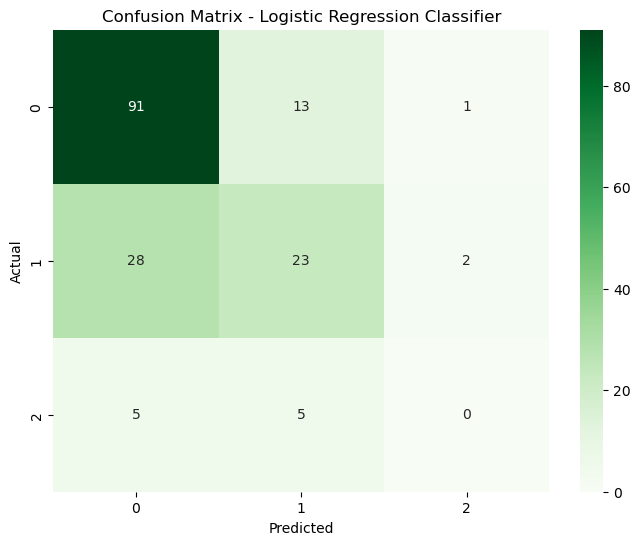

In [21]:
#define the logistic regression model pipeline
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

y_pred_lr = cross_val_predict(pipeline_lr, X, y, cv=cv, groups=groups)

print("Classification report for Logistic Regression:\n")
print(classification_report(y, y_pred_lr, zero_division=0))

cm_lr = confusion_matrix(y, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Logistic Regression Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
#redefine the model pipeline with the binned target variable
from sklearn.model_selection import train_test_split


y = y_binned

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cv = GroupKFold(n_splits=5)

pipeline_rf_binned = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42)  )
])

#cross-validate the model with the binned target variable
groups_train = groups.loc[X_train.index]
y_pred_rf_binned = cross_val_predict(pipeline_rf_binned, X_test, y_train, cv=cv, groups=groups_train)
#printing the classification report and confusion matrix for binned target variable
print("Classification Report for Binned Target Variable:\n")
print(classification_report(y_train, y_pred_rf_binned, zero_division=0))
print(classification_report(y_test, y_pred_rf_binned, zero_division=0))


# Confusion matrix for cross-validated predictions on the training set
cm_binned = confusion_matrix(y_train, y_pred_rf_binned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_binned, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - Random Forest Classifier (Binned, Train CV)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# If you want to evaluate on the test set:
pipeline_rf_binned.fit(X_train, y_train)
y_test_pred = pipeline_rf_binned.predict(X_test)
cm_binned_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_binned_test, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - Random Forest Classifier (Binned, Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [34, 34, 134]

**Model Comparison**

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred)
pr_auc = average_precision_score(y_test, y_pred)